<a href="https://colab.research.google.com/github/bkrant/DS-Unit-2-Sprint-4-Practicing-Understanding/blob/master/LS_DS_243_Model_Interpretation_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [0]:
def load(): 
    fremont_bridge = 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'
    
    bicycle_weather = 'https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv'

    counts = pd.read_csv(fremont_bridge, index_col='Date', parse_dates=True, 
                         infer_datetime_format=True)

    weather = pd.read_csv(bicycle_weather, index_col='DATE', parse_dates=True, 
                          infer_datetime_format=True)

    daily = counts.resample('d').sum()
    daily['Total'] = daily.sum(axis=1)
    daily = daily[['Total']] # remove other columns

    weather_columns = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND']
    daily = daily.join(weather[weather_columns], how='inner')
    
    # Make a feature for yesterday's total
    daily['Total_yesterday'] = daily.Total.shift(1)
    daily = daily.drop(index=daily.index[0])
    
    return daily

In [0]:
def split(daily):
    # Hold out an "out-of-time" test set, from the last 100 days of data
    
    train = daily[:-100]
    test = daily[-100:]
    
    X_train = train.drop(columns='Total')
    y_train = train.Total

    X_test  = test.drop(columns='Total')
    y_test  = test.Total
    ""
    return X_train, X_test, y_train, y_test

In [0]:
def jake_wrangle(X):  
    X = X.copy()

    # patterns of use generally vary from day to day; 
    # let's add binary columns that indicate the day of the week:
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    for i, day in enumerate(days):
        X[day] = (X.index.dayofweek == i).astype(float)


    # we might expect riders to behave differently on holidays; 
    # let's add an indicator of this as well:
    from pandas.tseries.holiday import USFederalHolidayCalendar
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays('2012', '2016')
    X = X.join(pd.Series(1, index=holidays, name='holiday'))
    X['holiday'].fillna(0, inplace=True)


    # We also might suspect that the hours of daylight would affect 
    # how many people ride; let's use the standard astronomical calculation 
    # to add this information:
    def hours_of_daylight(date, axis=23.44, latitude=47.61):
        """Compute the hours of daylight for the given date"""
        days = (date - pd.datetime(2000, 12, 21)).days
        m = (1. - np.tan(np.radians(latitude))
             * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
        return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

    X['daylight_hrs'] = list(map(hours_of_daylight, X.index))


    # temperatures are in 1/10 deg C; convert to C
    X['TMIN'] /= 10
    X['TMAX'] /= 10

    # We can also calcuate the average temperature.
    X['Temp (C)'] = 0.5 * (X['TMIN'] + X['TMAX'])


    # precip is in 1/10 mm; convert to inches
    X['PRCP'] /= 254

    # In addition to the inches of precipitation, let's add a flag that 
    # indicates whether a day is dry (has zero precipitation):
    X['dry day'] = (X['PRCP'] == 0).astype(int)


    # Let's add a counter that increases from day 1, and measures how many 
    # years have passed. This will let us measure any observed annual increase 
    # or decrease in daily crossings:
    X['annual'] = (X.index - X.index[0]).days / 365.

    return X

In [0]:
data = load()

In [0]:
def wrangle(X):
    X = X.copy()
    X = X.replace(-9999, 0)
    X = jake_wrangle(X)
    
    # DS1 DH
    X['PRCP_yesterday'] = X.PRCP.shift(1).fillna(X.PRCP.mean())
    X['Windchill'] = (((X['Temp (C)'] * (9/5) + 32) * .6215) + 34.74) - (35.75 * (X['AWND']** .16)) + (.4275 * (X['Temp (C)'])) * (X['AWND'] ** .16)
    X['Rl_Cold'] = (((X['Temp (C)'] * (9/5) + 32) - X['Windchill']) -32) * (5/9)
    X['TMIN_squared'] = X['TMIN'] **2
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for i, month in enumerate(months):
        X[month] = (X.index.month == i+1).astype(float)
    
    # DS3 JD
    X['light_rain'] = (X['PRCP'] > 0) & (X['PRCP'] < 0.10)
    X['moderate_rain'] = (X['PRCP'] >= 0.1) & (X['PRCP'] < 0.30)
    X['heavy_rain'] = (X['PRCP'] >= 0.30)
    X['weekend_day'] = (X['Sat'] == 1) | (X['Sun'] == 1)

    return X

In [12]:
data.describe(include='number')

,Total,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday
count,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000
mean,2632.449671,29.350894,-37.496707,0.098777,166.863594,84.472248,22.338664,2633.056444
std,1252.864020,65.813053,612.512583,2.570041,74.779734,50.916006,307.984292,1253.138245
min,98.000000,0.000000,-9999.000000,0.000000,-16.000000,-71.000000,-9999.000000,98.000000
25%,1806.000000,0.000000,0.000000,0.000000,111.000000,44.000000,22.000000,1806.000000
50%,2435.000000,0.000000,0.000000,0.000000,150.000000,83.000000,29.000000,2435.000000
75%,3574.500000,26.500000,0.000000,0.000000,222.000000,128.000000,40.000000,3574.500000
max,6088.000000,559.000000,74.000000,80.000000,356.000000,183.000000,95.000000,6088.000000


In [0]:
# Split data into train and test
X_train, X_test, y_train, y_test = split(data)

# Do the same wrangling to X_train and X_test
X_train = wrangle(X_train)
X_test  = wrangle(X_test)

In [15]:
X_train.describe(exclude='number')

,light_rain,moderate_rain,heavy_rain,weekend_day
count,963,963,963,963
unique,2,2,2,2
top,False,False,False,False
freq,794,837,829,687


In [69]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

param_distributions = {
    'n_estimators': randint(50, 500), 
    'max_depth': randint(1, 5)
}

search = RandomizedSearchCV(
    estimator=XGBRegressor(n_jobs=-1, random_state=42), 
    param_distributions=param_distributions, 
    n_iter=50, 
    scoring='neg_mean_absolute_error', 
    n_jobs=-1, 
    cv=3, 
    verbose=10, 
    return_train_score=True, 
    random_state=42
)

search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f55f27a8780>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f55f27f4dd8>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=10)

In [21]:
print('Mean Absolute Error with Cross-Validation:')
print(f'Predictions are off by {int(-search.best_score_)} bicyclists per day, on average')

Mean Absolute Error with Cross-Validation:
Predictions are off by 265 bicyclists per day, on average


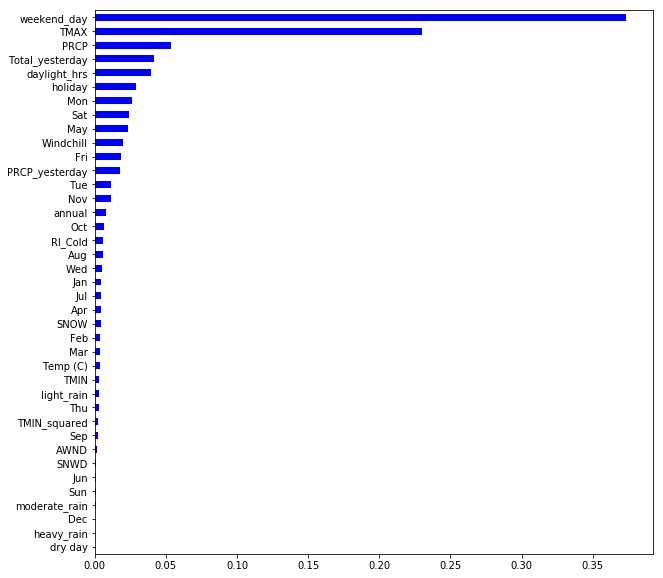

In [20]:
plt.figure(figsize=(10,10))
importances = pd.Series(search.best_estimator_.feature_importances_, X_train.columns)
importances.sort_values().plot.barh(color='blue');

In [0]:
pip install eli5
pip install pdpbox
pip install shap

In [74]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(search.best_estimator_, scoring='neg_mean_absolute_error', cv='prefit', 
                                 n_iter=2, random_state=42)

permuter.fit(X_train, y_train)

PermutationImportance(cv='prefit',
           estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=99, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
           n_iter=2, random_state=42, refit=True,
           scoring='neg_mean_absolute_error')

In [75]:
feature_names = X_train.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
483.7361 ± 2.5500,weekend_day
407.2661 ± 36.8291,TMAX
231.7655 ± 29.6776,PRCP
129.6043 ± 5.2886,daylight_hrs
127.5308 ± 0.2294,Total_yesterday
39.9543 ± 6.8833,annual
28.7322 ± 0.6362,holiday
26.8312 ± 0.2759,TMIN
25.6631 ± 1.7406,May
25.4481 ± 0.4173,Fri


In [77]:
permuter.fit(X_test, y_test)
feature_names = X_test.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
541.9207 ± 164.3276,weekend_day
83.5378 ± 19.2100,PRCP
67.9156 ± 4.9448,TMAX
54.0467 ± 6.0015,Total_yesterday
43.4952 ± 2.2825,Fri
22.5431 ± 10.6334,Tue
21.9257 ± 0.5402,holiday
19.8153 ± 0.9850,May
16.7914 ± 4.9598,Sat
14.4152 ± 15.9392,daylight_hrs


In [44]:
print('Shape before removing features:', X_train.shape)

Shape before removing features: (963, 19)


In [45]:
mask = permuter.feature_importances_ > 0
features = X_train.columns[mask]
X_train = X_train[features]
print('Shape after removing features:', X_train.shape)

Shape after removing features: (963, 17)


In [46]:
param_distributions = {
    'n_estimators': randint(50, 500), 
    'max_depth': randint(1, 5)
}

search = RandomizedSearchCV(
    estimator=XGBRegressor(n_jobs=-1, random_state=42), 
    param_distributions=param_distributions, 
    n_iter=50, 
    scoring='neg_mean_absolute_error', 
    n_jobs=-1, 
    cv=3, 
    verbose=10, 
    return_train_score=True, 
    random_state=42
)

search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f55f52281d0>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f55f5290240>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=10)

In [48]:
print('Mean Absolute Error with Cross-Validation:')
print(f'Predictions are off by {int(-search.best_score_)} bicyclists per day, on average')

Mean Absolute Error with Cross-Validation:
Predictions are off by 265 bicyclists per day, on average


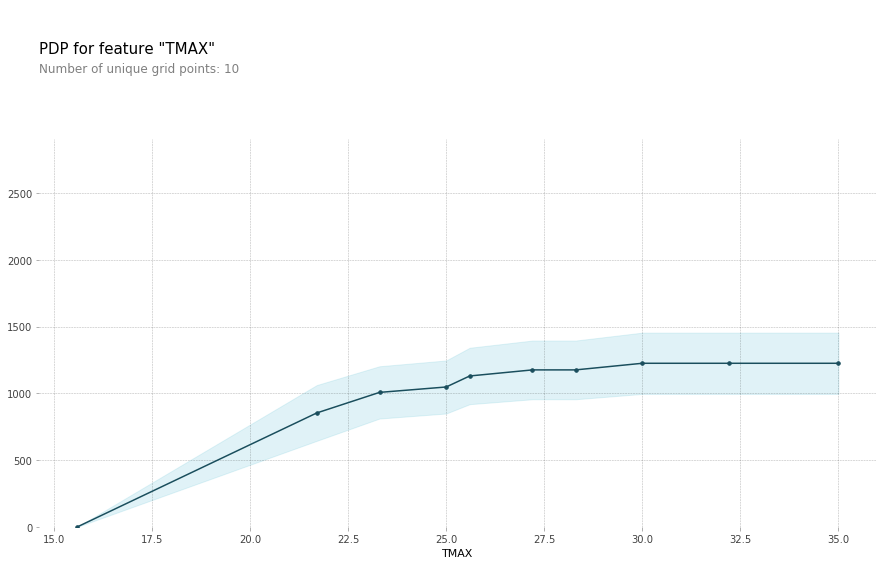

In [80]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'TMAX'

isolated = pdp_isolate(
    model=search.best_estimator_, 
    dataset=X_test, 
    model_features=X_test.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

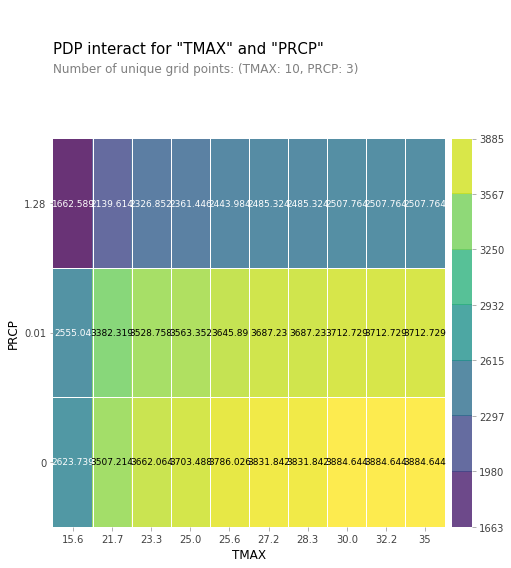

<Figure size 1440x1440 with 0 Axes>

In [86]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['TMAX', 'PRCP']

interaction = pdp_interact(
    model=search.best_estimator_, 
    dataset=X_test, 
    model_features=X_test.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);
plt.figure(figsize=(20,20));

In [90]:
X_test.head(2)

,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,Temp (C),dry day,annual,PRCP_yesterday,Windchill,Rl_Cold,TMIN_squared,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,light_rain,moderate_rain,heavy_rain,weekend_day
2015-05-25,0.0,0,0,15.6,11.1,27,1776.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.269661,13.35,1,0.00000,0.038307,18.657733,2.984593,123.21,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
2015-05-26,0.0,0,0,21.7,11.7,21,1737.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,15.303607,16.70,1,0.00274,0.000000,26.742639,1.842978,136.89,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False


In [99]:
data_for_prediction = X_test.iloc[1:2,:]
data_for_prediction

,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,Temp (C),dry day,annual,PRCP_yesterday,Windchill,Rl_Cold,TMIN_squared,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,light_rain,moderate_rain,heavy_rain,weekend_day
2015-05-26,0.0,0,0,21.7,11.7,21,1737.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,15.303607,16.7,1,0.00274,0.0,26.742639,1.842978,136.89,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False


In [102]:
search.best_estimator_.predict(data_for_prediction)

array([4306.0674], dtype=float32)

In [101]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(search.best_estimator_)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)